
=== Pruning with Scale Metric: norm ===


/tmp/ipykernel_4083396/1880648171.py:170: RuntimeWarning: invalid value encountered in log10
  scale_values_for_color = np.log10(scale_values_clipped + 1e-6)


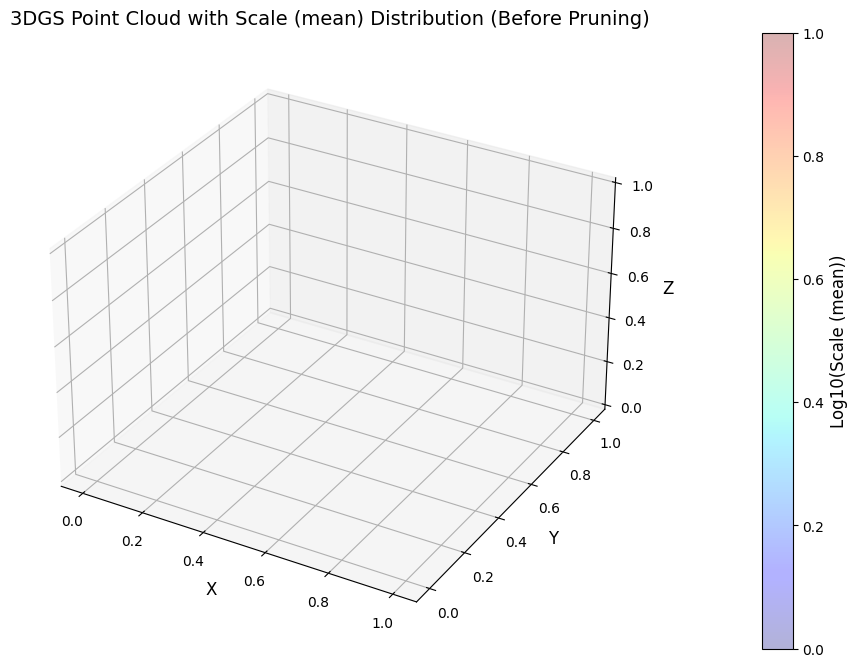

Scale Pruning (norm): Pruned 160000 points with scale > 6.4638, Remaining 40000 points


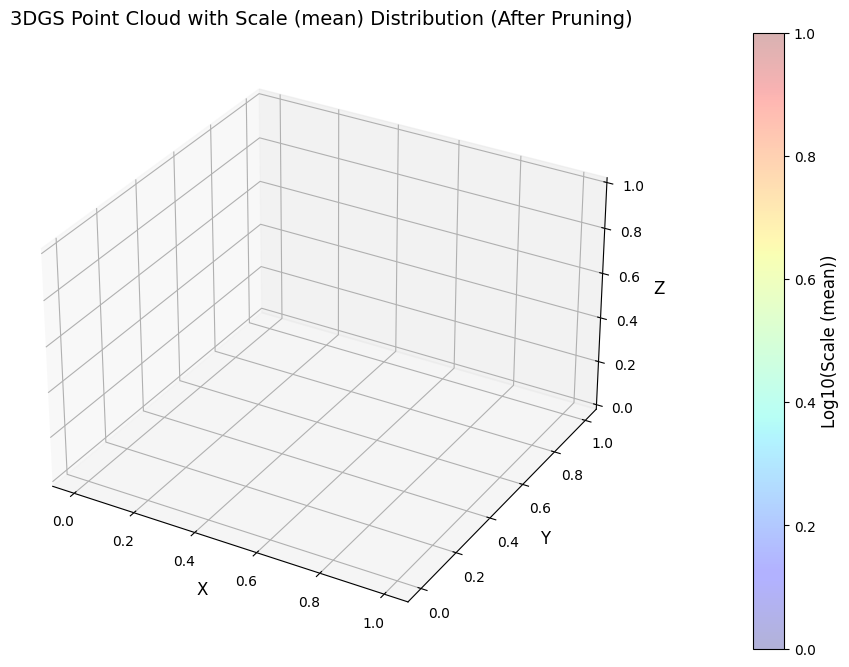


=== Pruning with Scale Metric: mean ===


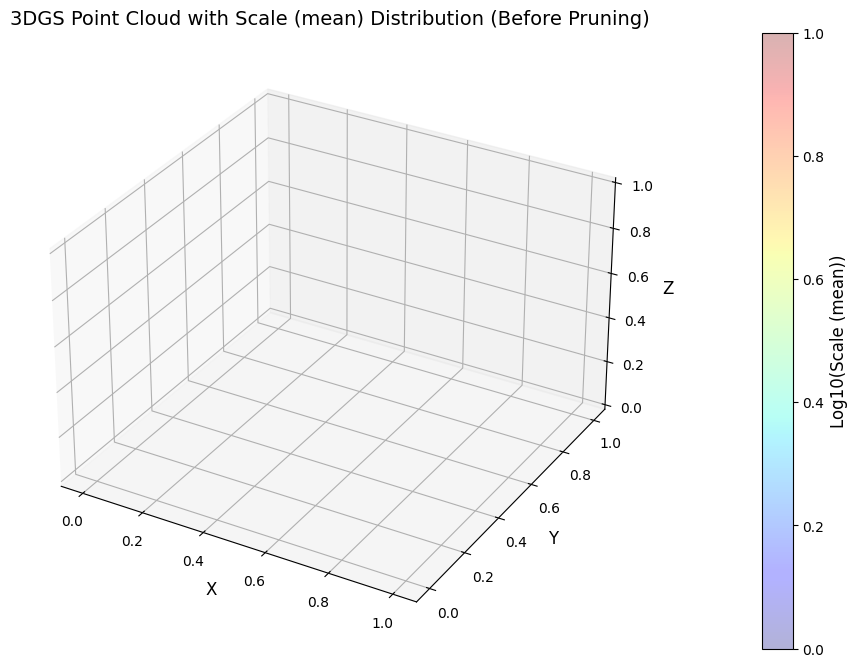

Scale Pruning (mean): Pruned 160000 points with scale > -4.6816, Remaining 40000 points


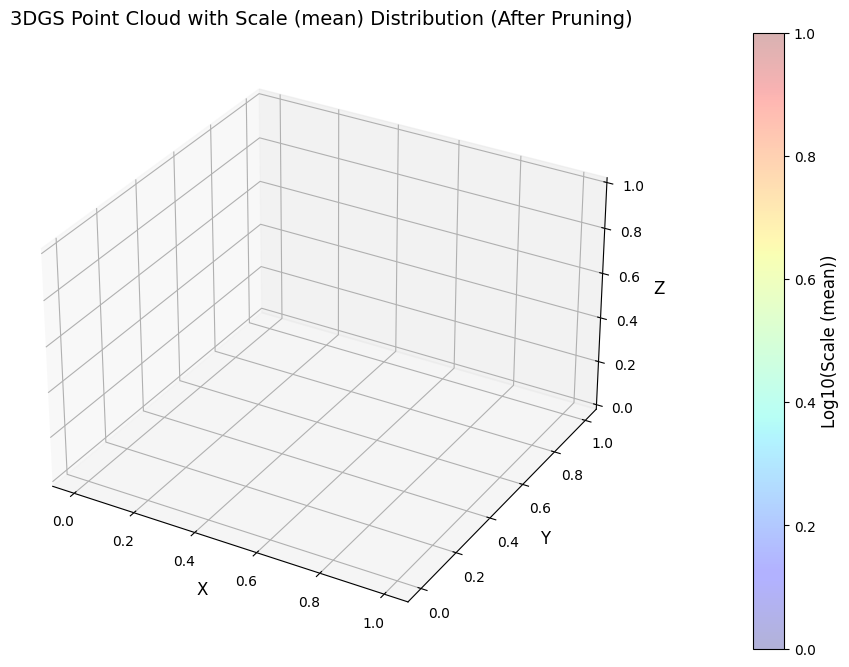


=== Pruning with Scale Metric: max ===


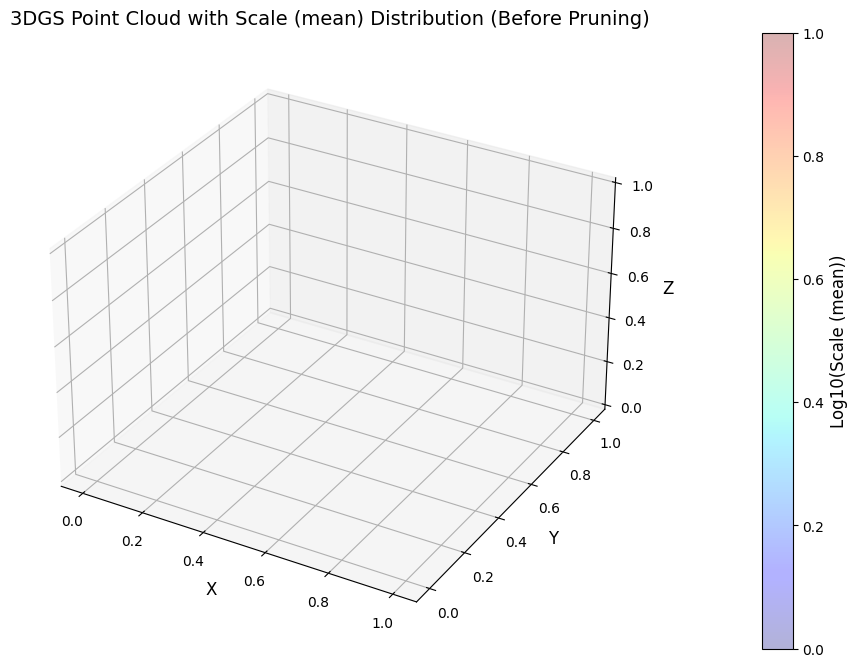

Scale Pruning (max): Pruned 159999 points with scale > -3.9498, Remaining 40001 points


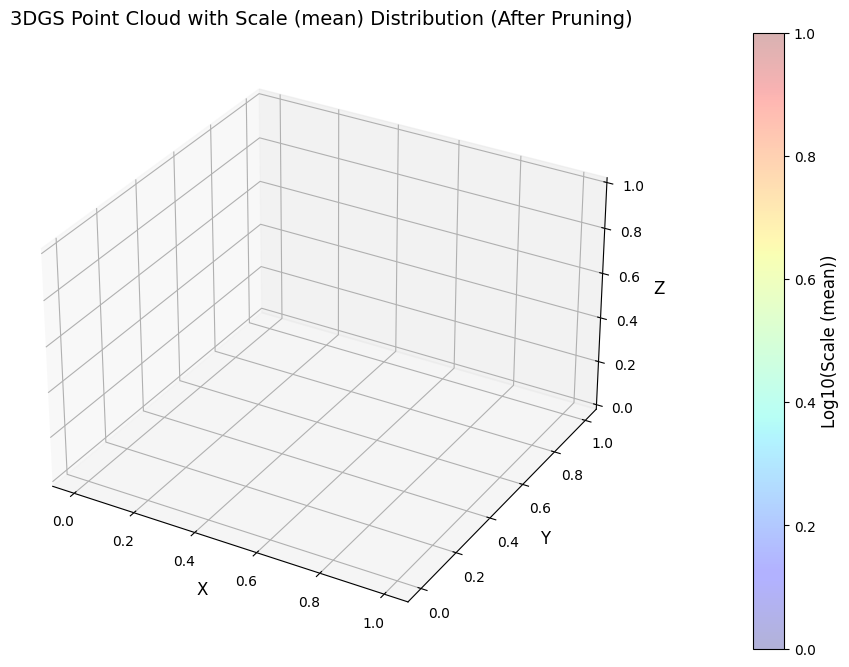


=== Pruning with Scale Metric: min ===


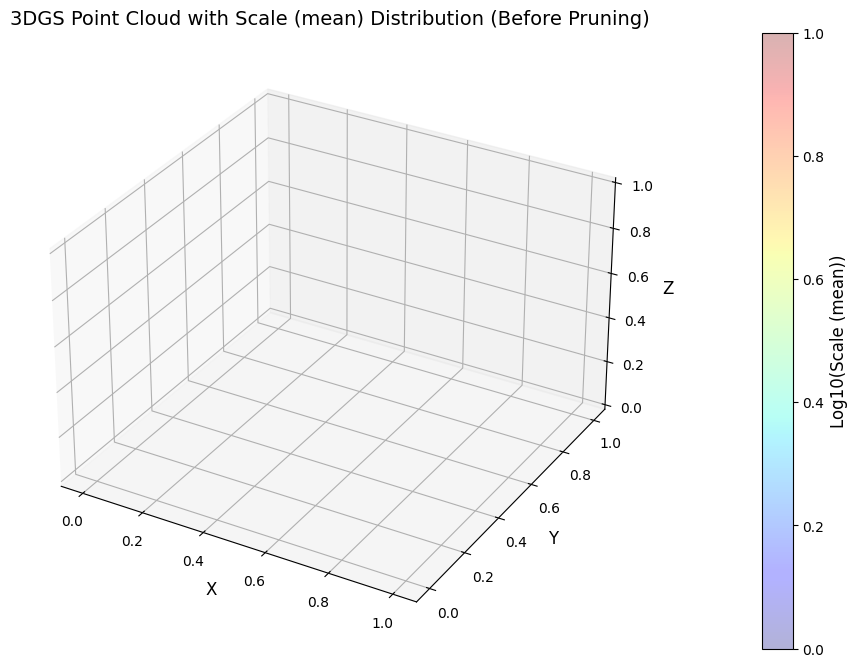

Scale Pruning (min): Pruned 160000 points with scale > -5.6453, Remaining 40000 points


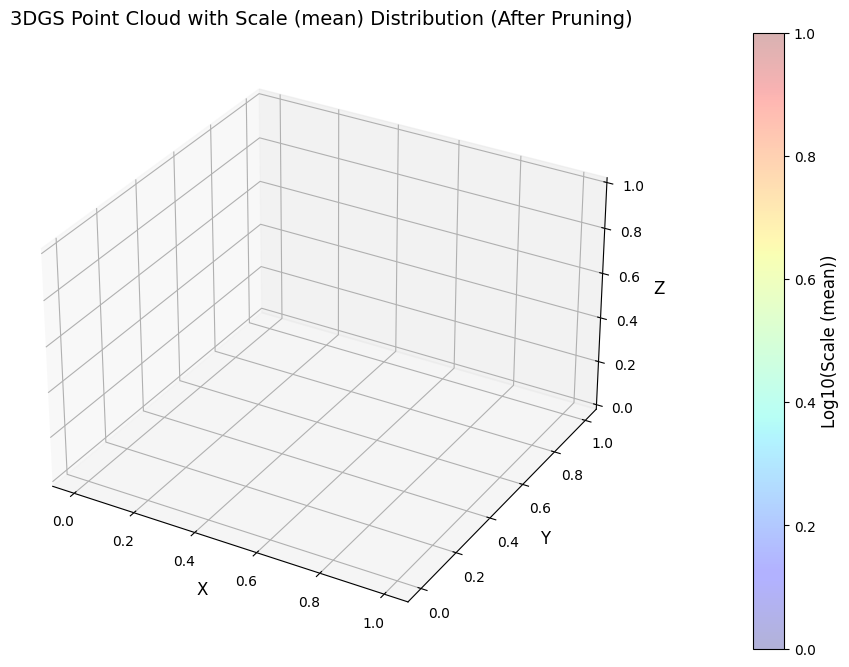

In [ ]:
# Jupyter Notebook에서 실행 가능한 코드
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from plyfile import PlyData

# 3DGS 데이터 로드 함수
def load_3dgs_data_with_attributes(path_3dgs):
    """
    Load 3DGS data with attributes from a PLY file.
    
    Args:
        path_3dgs (str): Path to the 3DGS PLY file
    
    Returns:
        points_3dgs (np.ndarray): 3DGS points [N, 3]
        colors_3dgs (np.ndarray): 3DGS colors [N, 3]
        features_3dgs (np.ndarray): 3DGS attributes [N, 8] (scale_x, scale_y, scale_z, opacity, rot_w, rot_x, rot_y, rot_z)
    """
    with open(path_3dgs, 'rb') as f:
        ply_data_3dgs = PlyData.read(f)
    vertex_data_3dgs = ply_data_3dgs['vertex']
    
    points_3dgs = np.stack([vertex_data_3dgs['x'], vertex_data_3dgs['y'], vertex_data_3dgs['z']], axis=-1)
    
    # SH 1차 계수 (f_dc_0, f_dc_1, f_dc_2) -> RGB
    colors_3dgs = np.stack([vertex_data_3dgs['f_dc_0'], vertex_data_3dgs['f_dc_1'], vertex_data_3dgs['f_dc_2']], axis=-1)
    # SH 계수는 일반적으로 [-1, 1] 범위로 저장됨 -> [0, 1]로 정규화
    colors_3dgs = (colors_3dgs + 1.0) / 2.0  # [-1, 1] -> [0, 1]
    colors_3dgs = np.clip(colors_3dgs, 0.0, 1.0)  # 범위 제한

    scales_3dgs = np.stack([vertex_data_3dgs['scale_0'], vertex_data_3dgs['scale_1'], vertex_data_3dgs['scale_2']], axis=-1)
    opacity_3dgs = vertex_data_3dgs['opacity']
    rotation_3dgs = np.stack([vertex_data_3dgs['rot_0'], vertex_data_3dgs['rot_1'], vertex_data_3dgs['rot_2'], vertex_data_3dgs['rot_3']], axis=-1)  # Quaternion (w, x, y, z)
    
    features_3dgs = np.hstack((scales_3dgs, opacity_3dgs[:, np.newaxis], rotation_3dgs))
    return points_3dgs, colors_3dgs, features_3dgs

# 속성 전처리 함수
def preprocessing_attr(raw_features_3dgs, normalize_scale=True):
    """
    Preprocess raw 3DGS attributes to make them usable.
    
    Args:
        raw_features_3dgs (np.ndarray): Raw 3DGS attributes [N, 8] (scale_x, scale_y, scale_z, opacity, rot_w, rot_x, rot_y, rot_z)
        normalize_scale (bool): Whether to normalize scale values to [0, 1]. Default is True.
    
    Returns:
        features_3dgs (np.ndarray): Processed 3DGS attributes [N, 8] (scale_x, scale_y, scale_z, opacity, rot_w, rot_x, rot_y, rot_z)
    """
    # 속성 분리
    scale = raw_features_3dgs[:, 0:3]  # [N, 3] (scale_x, scale_y, scale_z)
    opacity = raw_features_3dgs[:, 3:4]  # [N, 1] (opacity)
    rotation = raw_features_3dgs[:, 4:8]  # [N, 4] (rot_w, rot_x, rot_y, rot_z)

    # Scale: 로그 변환 해제
    scale_processed = np.exp(scale)  # log(scale) -> scale
    scale_processed = np.nan_to_num(scale_processed, nan=1e-6, posinf=1e-6, neginf=1e-6)
    scale_processed = np.maximum(scale_processed, 1e-6)  # 양수 보장

    # Scale 정규화 (옵션)
    if normalize_scale:
        scale_min = scale_processed.min()
        scale_max = scale_processed.max()
        if scale_max > scale_min:  # 분모가 0이 되지 않도록
            scale_processed = (scale_processed - scale_min) / (scale_max - scale_min)
        else:
            scale_processed = np.zeros_like(scale_processed)  # 모든 값이 동일하면 0으로 설정

    # Opacity: 시그모이드 변환
    opacity_processed = 1 / (1 + np.exp(-opacity))  # [-∞, ∞] -> [0, 1]
    opacity_processed = np.nan_to_num(opacity_processed, nan=0.0, posinf=1.0, neginf=0.0)
    opacity_processed = np.clip(opacity_processed, 0.0, 1.0)  # [0, 1]로 클리핑

    # Rotation: 쿼터니언 정규화
    rotation_norm = np.linalg.norm(rotation, axis=1, keepdims=True)
    rotation_processed = np.where(rotation_norm > 0, rotation / rotation_norm, rotation)

    # 후처리된 속성 결합
    features_3dgs = np.hstack((scale_processed, opacity_processed, rotation_processed))
    return features_3dgs

# Scale-Based Pruning 함수
def prune_by_scale(points_3dgs, features_3dgs, scale_ratio, scale_metric='norm'):
    """
    Prune points based on scale values (remove top scale_ratio% points).
    
    Args:
        points_3dgs (np.ndarray): 3DGS points [N, 3] (x, y, z)
        features_3dgs (np.ndarray): 3DGS attributes [N, 8] (scale_x, scale_y, scale_z, opacity, rot_w, rot_x, rot_y, rot_z)
        scale_ratio (float): Ratio of points to prune (e.g., 0.1 = 10%)
        scale_metric (str): Metric to compute scale magnitude ('norm', 'mean', 'max', 'min')
    
    Returns:
        points_pruned (np.ndarray): Pruned points [M, 3]
        features_pruned (np.ndarray): Pruned features [M, 8]
        mask (np.ndarray): Boolean mask of kept points [N,]
    """
    # Scale 값 추출 (이미 exp(scale)로 복원된 상태)
    scales = features_3dgs[:, 0:3]  # [N, 3] (scale_x, scale_y, scale_z)

    # Scale 크기 계산
    if scale_metric == 'norm':
        scale_magnitudes = np.linalg.norm(scales, axis=-1)
    elif scale_metric == 'mean':
        scale_magnitudes = np.mean(scales, axis=-1)
    elif scale_metric == 'max':
        scale_magnitudes = np.max(scales, axis=-1)
    elif scale_metric == 'min':
        scale_magnitudes = np.min(scales, axis=-1)
    else:
        raise ValueError("scale_metric must be one of 'norm', 'mean', 'max', 'min'")

    # Threshold 계산 (상위 scale_ratio% 제거)
    threshold = np.percentile(scale_magnitudes, 100 * (1 - scale_ratio))
    mask = scale_magnitudes <= threshold  # 큰 값 제거

    # Pruned 데이터 생성
    points_pruned = points_3dgs[mask]
    features_pruned = features_3dgs[mask]

    print(f"Scale Pruning ({scale_metric}): Pruned {np.sum(~mask)} points with scale > {threshold:.4f}, Remaining {np.sum(mask)} points")

    return points_pruned, features_pruned, mask

# 3DGS 포인트 클라우드 시각화 함수
def visualize_3dgs_scale(points_3dgs, features_3dgs, scale_dim='mean', scale_range=None, point_size=1, use_log_scale=True, percentile_range=(5, 95), title_suffix=""):
    """
    Visualize 3DGS point cloud with scale values mapped to colors.
    
    Args:
        points_3dgs (np.ndarray): 3DGS points [N, 3] (x, y, z)
        features_3dgs (np.ndarray): 3DGS attributes [N, 8] (scale_x, scale_y, scale_z, opacity, rot_w, rot_x, rot_y, rot_z)
        scale_dim (str): Which scale dimension to visualize ('mean', 'scale_x', 'scale_y', 'scale_z')
        scale_range (tuple): (min, max) range for scale color mapping. If None, use data range.
        point_size (float): Size of points in the scatter plot.
        use_log_scale (bool): Whether to use log scale for color mapping.
        percentile_range (tuple): (lower, upper) percentiles for color mapping range.
        title_suffix (str): Suffix to add to the plot title.
    """
    # Scale 값 추출
    scale_x = features_3dgs[:, 0]  # scale_x
    scale_y = features_3dgs[:, 1]  # scale_y
    scale_z = features_3dgs[:, 2]  # scale_z

    # Scale 값 선택
    if scale_dim == 'mean':
        scale_values = np.mean(features_3dgs[:, 0:3], axis=1)  # scale_x, scale_y, scale_z의 평균
    elif scale_dim == 'scale_x':
        scale_values = scale_x
    elif scale_dim == 'scale_y':
        scale_values = scale_y
    elif scale_dim == 'scale_z':
        scale_values = scale_z
    else:
        raise ValueError("scale_dim must be one of 'mean', 'scale_x', 'scale_y', 'scale_z'")

    # Scale 값 범위 설정
    if scale_range is None:
        # 백분위수 기반 범위 설정
        scale_min = np.percentile(scale_values, percentile_range[0])
        scale_max = np.percentile(scale_values, percentile_range[1])
    else:
        scale_min, scale_max = scale_range
    scale_values_clipped = np.clip(scale_values, scale_min, scale_max)

    # 로그 스케일 적용 (옵션)
    if use_log_scale:
        # 0 이하 값 방지를 위해 작은 값을 더함
        scale_values_for_color = np.log10(scale_values_clipped + 1e-6)
        cbar_label = f'Log10(Scale ({scale_dim}))'
    else:
        scale_values_for_color = scale_values_clipped
        cbar_label = f'Scale ({scale_dim})'

    # 3D 산점도 생성
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 포인트 클라우드 시각화
    scatter = ax.scatter(
        points_3dgs[:, 0],  # x
        points_3dgs[:, 1],  # y
        points_3dgs[:, 2],  # z
        c=scale_values_for_color,  # 색상은 scale 값에 따라 매핑
        cmap='jet',               # 색상 맵 (파랑 -> 빨강)
        s=point_size,             # 포인트 크기
        alpha=0.3                 # 투명도
    )

    # 색상 바 추가
    cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label(cbar_label, fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # 축 라벨 설정
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)

    # 제목 설정
    ax.set_title(f'3DGS Point Cloud with Scale ({scale_dim}) Distribution {title_suffix}', fontsize=14)

    # 축 비율 조정
    ax.set_box_aspect([1.5, 1.5, 1])  # x, y, z 축 비율을 동일하게 설정

    plt.show()

# 데이터 로드 및 전처리
path_3dgs = "/home/knuvi/Desktop/song/data/3dgs_scans/3dgs_output/scene0011_00/point_cloud.ply"
points_3dgs, colors_3dgs, raw_features_3dgs = load_3dgs_data_with_attributes(path_3dgs)
features_3dgs = preprocessing_attr(raw_features_3dgs, normalize_scale=True)

# 포인트 수가 너무 많으면 샘플링
max_points = 200000
if len(points_3dgs) > max_points:
    indices = np.random.choice(len(points_3dgs), max_points, replace=False)
    points_3dgs = points_3dgs[indices]
    features_3dgs = features_3dgs[indices]

# Pruning 설정
scale_ratio = 0.50  # 상위 10% 제거
scale_metrics = ['norm', 'mean', 'max', 'min']  # Scale 크기 계산 방식
scale_dims = ['mean']  # 시각화할 Scale 차원

# Before 및 After 시각화
for scale_metric in scale_metrics:
    print(f"\n=== Pruning with Scale Metric: {scale_metric} ===")
    
    # Before Pruning 시각화
    for scale_dim in scale_dims:
        visualize_3dgs_scale(
            points_3dgs,
            features_3dgs,
            scale_dim=scale_dim,
            scale_range=None,
            point_size=1,
            use_log_scale=True,
            percentile_range=(5, 95),
            title_suffix="(Before Pruning)"
        )

    # Pruning 적용
    points_pruned, features_pruned, mask = prune_by_scale(
        points_3dgs,
        features_3dgs,
        scale_ratio=scale_ratio,
        scale_metric=scale_metric
    )

    # After Pruning 시각화
    for scale_dim in scale_dims:
        visualize_3dgs_scale(
            points_pruned,
            features_pruned,
            scale_dim=scale_dim,
            scale_range=None,
            point_size=1,
            use_log_scale=True,
            percentile_range=(5, 95),
            title_suffix="(After Pruning)"
        )


=== Pruning with Scale Metric: norm ===


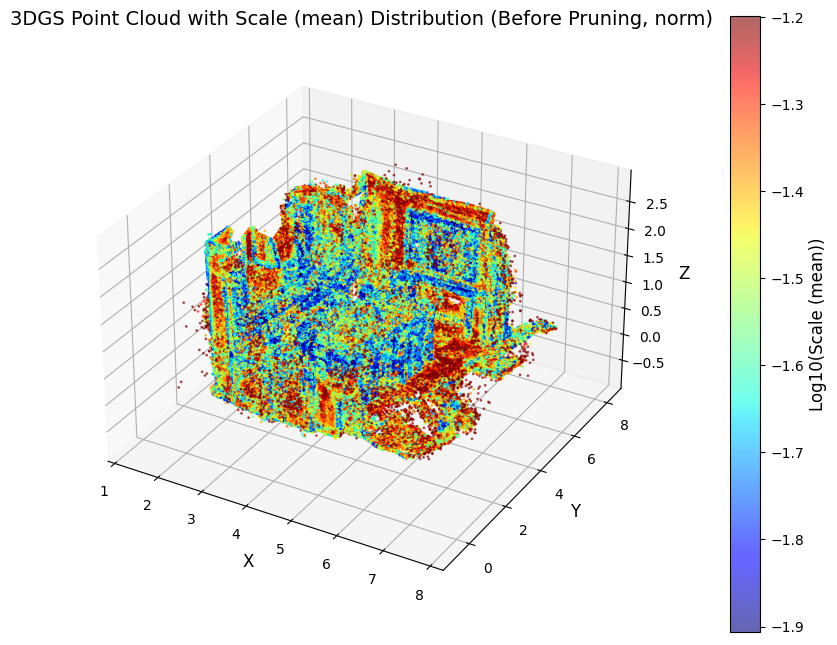

Scale Pruning (norm): Pruned 200000 points with scale > 0.0344, Remaining 50000 points


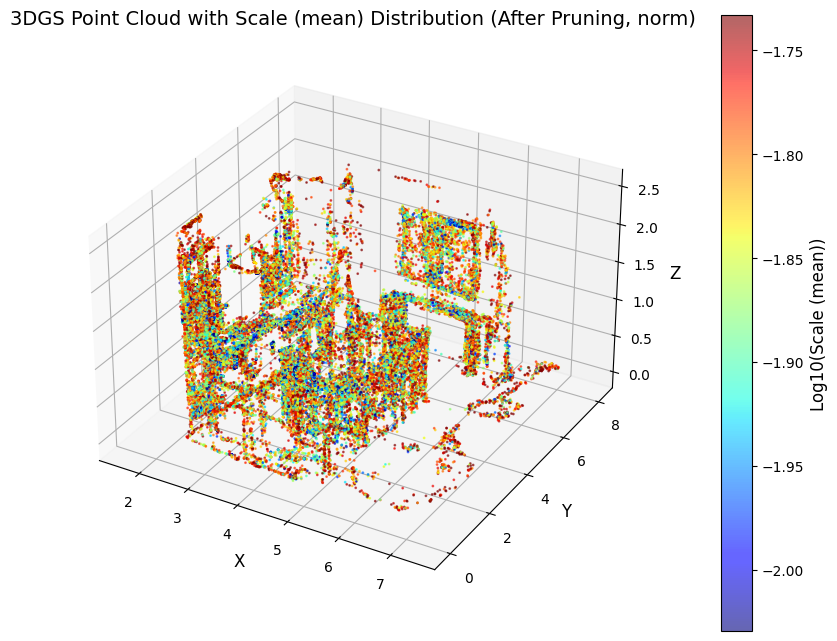


=== Pruning with Scale Metric: mean_norm ===


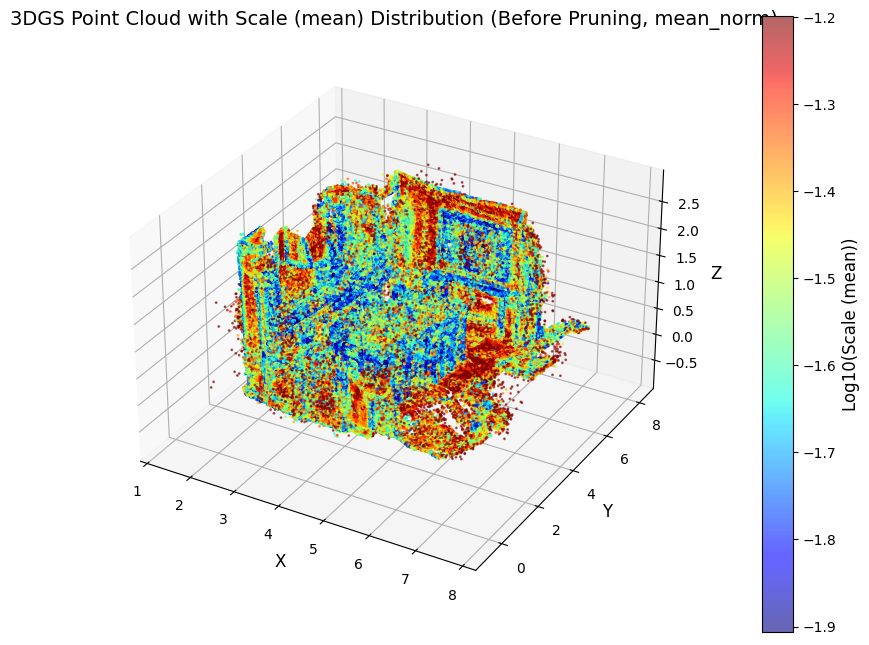

Scale Pruning (mean_norm): Pruned 200000 points with scale > 0.0174, Remaining 50000 points


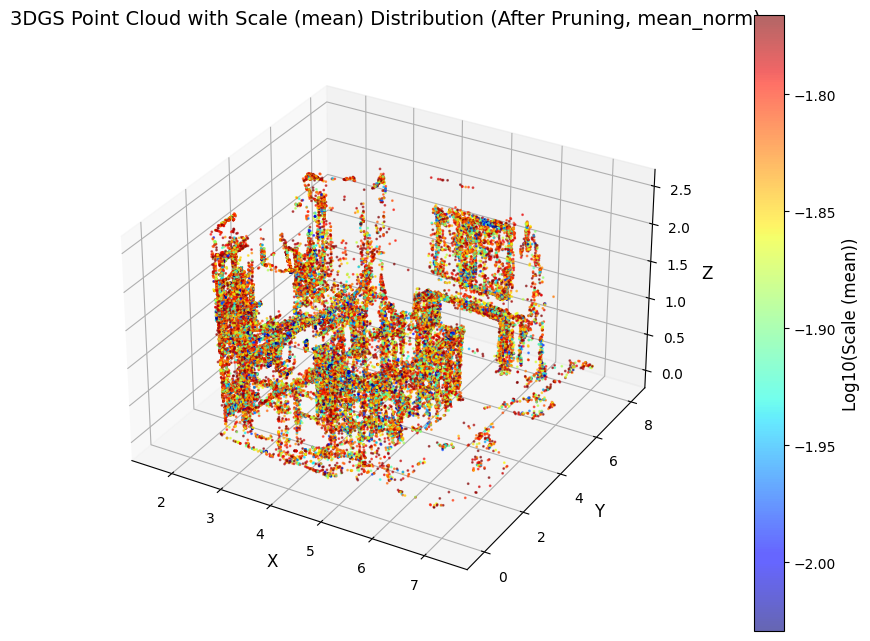

In [26]:
# Jupyter Notebook에서 실행 가능한 코드
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from plyfile import PlyData

# 3DGS 데이터 로드 함수
def load_3dgs_data_with_attributes(path_3dgs):
    """
    Load 3DGS data with attributes from a PLY file.
    
    Args:
        path_3dgs (str): Path to the 3DGS PLY file
    
    Returns:
        points_3dgs (np.ndarray): 3DGS points [N, 3]
        colors_3dgs (np.ndarray): 3DGS colors [N, 3]
        features_3dgs (np.ndarray): 3DGS attributes [N, 8] (scale_x, scale_y, scale_z, opacity, rot_w, rot_x, rot_y, rot_z)
    """
    with open(path_3dgs, 'rb') as f:
        ply_data_3dgs = PlyData.read(f)
    vertex_data_3dgs = ply_data_3dgs['vertex']
    
    points_3dgs = np.stack([vertex_data_3dgs['x'], vertex_data_3dgs['y'], vertex_data_3dgs['z']], axis=-1)
    
    # SH 1차 계수 (f_dc_0, f_dc_1, f_dc_2) -> RGB
    colors_3dgs = np.stack([vertex_data_3dgs['f_dc_0'], vertex_data_3dgs['f_dc_1'], vertex_data_3dgs['f_dc_2']], axis=-1)
    # SH 계수는 일반적으로 [-1, 1] 범위로 저장됨 -> [0, 1]로 정규화
    colors_3dgs = (colors_3dgs + 1.0) / 2.0  # [-1, 1] -> [0, 1]
    colors_3dgs = np.clip(colors_3dgs, 0.0, 1.0)  # 범위 제한

    scales_3dgs = np.stack([vertex_data_3dgs['scale_0'], vertex_data_3dgs['scale_1'], vertex_data_3dgs['scale_2']], axis=-1)
    opacity_3dgs = vertex_data_3dgs['opacity']
    rotation_3dgs = np.stack([vertex_data_3dgs['rot_0'], vertex_data_3dgs['rot_1'], vertex_data_3dgs['rot_2'], vertex_data_3dgs['rot_3']], axis=-1)  # Quaternion (w, x, y, z)
    
    features_3dgs = np.hstack((scales_3dgs, opacity_3dgs[:, np.newaxis], rotation_3dgs))
    return points_3dgs, colors_3dgs, features_3dgs

# 속성 전처리 함수
def preprocessing_attr(raw_features_3dgs, normalize_scale=True):
    """
    Preprocess raw 3DGS attributes to make them usable.
    
    Args:
        raw_features_3dgs (np.ndarray): Raw 3DGS attributes [N, 8] (scale_x, scale_y, scale_z, opacity, rot_w, rot_x, rot_y, rot_z)
        normalize_scale (bool): Whether to normalize scale values to [0, 1]. Default is True.
    
    Returns:
        features_3dgs (np.ndarray): Processed 3DGS attributes [N, 8] (scale_x, scale_y, scale_z, opacity, rot_w, rot_x, rot_y, rot_z)
    """
    # 속성 분리
    scale = raw_features_3dgs[:, 0:3]  # [N, 3] (scale_x, scale_y, scale_z)
    opacity = raw_features_3dgs[:, 3:4]  # [N, 1] (opacity)
    rotation = raw_features_3dgs[:, 4:8]  # [N, 4] (rot_w, rot_x, rot_y, rot_z)

    # Scale: 로그 변환 해제
    scale_processed = np.exp(scale)  # log(scale) -> scale
    scale_processed = np.nan_to_num(scale_processed, nan=1e-6, posinf=1e-6, neginf=1e-6)
    scale_processed = np.maximum(scale_processed, 1e-6)  # 양수 보장

    # Scale 정규화 (옵션)
    if normalize_scale:
        scale_min = scale_processed.min()
        scale_max = scale_processed.max()
        if scale_max > scale_min:  # 분모가 0이 되지 않도록
            scale_processed = (scale_processed - scale_min) / (scale_max - scale_min)
        else:
            scale_processed = np.zeros_like(scale_processed)  # 모든 값이 동일하면 0으로 설정

    # Opacity: 시그모이드 변환
    opacity_processed = 1 / (1 + np.exp(-opacity))  # [-∞, ∞] -> [0, 1]
    opacity_processed = np.nan_to_num(opacity_processed, nan=0.0, posinf=1.0, neginf=0.0)
    opacity_processed = np.clip(opacity_processed, 0.0, 1.0)  # [0, 1]로 클리핑

    # Rotation: 쿼터니언 정규화
    rotation_norm = np.linalg.norm(rotation, axis=1, keepdims=True)
    rotation_processed = np.where(rotation_norm > 0, rotation / rotation_norm, rotation)

    # 후처리된 속성 결합
    features_3dgs = np.hstack((scale_processed, opacity_processed, rotation_processed))
    return features_3dgs

# Scale-Based Pruning 함수
def prune_by_scale(points_3dgs, features_3dgs, scale_ratio, scale_metric='norm'):
    """
    Prune points based on scale values (remove top scale_ratio% points).
    
    Args:
        points_3dgs (np.ndarray): 3DGS points [N, 3] (x, y, z)
        features_3dgs (np.ndarray): 3DGS attributes [N, 8] (scale_x, scale_y, scale_z, opacity, rot_w, rot_x, rot_y, rot_z)
        scale_ratio (float): Ratio of points to prune (e.g., 0.1 = 10%)
        scale_metric (str): Metric to compute scale magnitude ('norm', 'mean', 'mean_norm')
    
    Returns:
        points_pruned (np.ndarray): Pruned points [M, 3]
        features_pruned (np.ndarray): Pruned features [M, 8]
        mask (np.ndarray): Boolean mask of kept points [N,]
    """
    # Scale 값 추출 (exp(scale)로 복원된 상태)
    scales = features_3dgs[:, 0:3]  # [N, 3] (scale_x, scale_y, scale_z)

    # Scale 크기 계산
    if scale_metric == 'norm':
        scale_magnitudes = np.linalg.norm(scales, axis=-1)  # L2 norm
    elif scale_metric == 'mean':
        scale_magnitudes = np.mean(scales, axis=-1)  # 평균값
    elif scale_metric == 'mean_norm':
        scale_means = np.mean(scales, axis=-1)  # 평균값 [N,]
        scale_magnitudes = np.abs(scale_means)  # 스칼라에 대한 L2 norm (절대값과 동일)
    else:
        raise ValueError("scale_metric must be one of 'norm', 'mean', 'mean_norm'")

    # Threshold 계산 (상위 scale_ratio% 제거)
    threshold = np.percentile(scale_magnitudes, 100 * (1 - scale_ratio))
    mask = scale_magnitudes <= threshold  # 큰 값 제거

    # Pruned 데이터 생성
    points_pruned = points_3dgs[mask]
    features_pruned = features_3dgs[mask]

    print(f"Scale Pruning ({scale_metric}): Pruned {np.sum(~mask)} points with scale > {threshold:.4f}, Remaining {np.sum(mask)} points")

    return points_pruned, features_pruned, mask

# 3DGS 포인트 클라우드 시각화 함수
def visualize_3dgs_scale(points_3dgs, features_3dgs, scale_dim='mean', scale_range=None, point_size=1, use_log_scale=True, percentile_range=(5, 95), title_suffix=""):
    """
    Visualize 3DGS point cloud with scale values mapped to colors.
    
    Args:
        points_3dgs (np.ndarray): 3DGS points [N, 3] (x, y, z)
        features_3dgs (np.ndarray): 3DGS attributes [N, 8] (scale_x, scale_y, scale_z, opacity, rot_w, rot_x, rot_y, rot_z)
        scale_dim (str): Which scale dimension to visualize ('mean', 'scale_x', 'scale_y', 'scale_z')
        scale_range (tuple): (min, max) range for scale color mapping. If None, use data range.
        point_size (float): Size of points in the scatter plot.
        use_log_scale (bool): Whether to use log scale for color mapping.
        percentile_range (tuple): (lower, upper) percentiles for color mapping range.
        title_suffix (str): Suffix to add to the plot title.
    """
    # Scale 값 추출
    scale_x = features_3dgs[:, 0]  # scale_x
    scale_y = features_3dgs[:, 1]  # scale_y
    scale_z = features_3dgs[:, 2]  # scale_z

    # Scale 값 선택
    if scale_dim == 'mean':
        scale_values = np.mean(features_3dgs[:, 0:3], axis=1)  # scale_x, scale_y, scale_z의 평균
    elif scale_dim == 'scale_x':
        scale_values = scale_x
    elif scale_dim == 'scale_y':
        scale_values = scale_y
    elif scale_dim == 'scale_z':
        scale_values = scale_z
    else:
        raise ValueError("scale_dim must be one of 'mean', 'scale_x', 'scale_y', 'scale_z'")

    # Scale 값 범위 설정
    if scale_range is None:
        # 백분위수 기반 범위 설정
        scale_min = np.percentile(scale_values, percentile_range[0])
        scale_max = np.percentile(scale_values, percentile_range[1])
    else:
        scale_min, scale_max = scale_range
    scale_values_clipped = np.clip(scale_values, scale_min, scale_max)

    # 로그 스케일 적용 (옵션)
    if use_log_scale:
        # 0 이하 값 방지를 위해 작은 값을 더함
        scale_values_for_color = np.log10(scale_values_clipped + 1e-6)
        cbar_label = f'Log10(Scale ({scale_dim}))'
    else:
        scale_values_for_color = scale_values_clipped
        cbar_label = f'Scale ({scale_dim})'

    # 3D 산점도 생성
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 포인트 클라우드 시각화
    scatter = ax.scatter(
        points_3dgs[:, 0],  # x
        points_3dgs[:, 1],  # y
        points_3dgs[:, 2],  # z
        c=scale_values_for_color,  # 색상은 scale 값에 따라 매핑
        cmap='jet',               # 색상 맵 (파랑 -> 빨강)
        s=point_size,             # 포인트 크기
        alpha=0.6                 # 투명도
    )

    # 색상 바 추가
    cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label(cbar_label, fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # 축 라벨 설정
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)

    # 제목 설정
    ax.set_title(f'3DGS Point Cloud with Scale ({scale_dim}) Distribution {title_suffix}', fontsize=14)

    # 축 비율 조정
    ax.set_box_aspect([1.5, 1.5, 1])  # x, y, z 축 비율을 동일하게 설정

    plt.show()

# 데이터 로드
path_3dgs = "/home/knuvi/Desktop/song/data/3dgs_scans/3dgs_output/scene0011_00/point_cloud.ply"
points_3dgs, colors_3dgs, raw_features_3dgs = load_3dgs_data_with_attributes(path_3dgs)

# 포인트 수가 너무 많으면 샘플링
max_points = 250000
if len(points_3dgs) > max_points:
    indices = np.random.choice(len(points_3dgs), max_points, replace=False)
    points_3dgs = points_3dgs[indices]
    raw_features_3dgs = raw_features_3dgs[indices]

# 전처리 (exp(scale) 적용)
features_3dgs = preprocessing_attr(raw_features_3dgs, normalize_scale=True)

# Pruning 설정
scale_ratio = 0.8  # 상위 10% 제거
scale_metrics = ['norm', 'mean_norm']  # 비교를 위해 'norm'과 'mean_norm' 사용
scale_dims = ['mean']  # 시각화할 Scale 차원

# Before 및 After 시각화
for scale_metric in scale_metrics:
    print(f"\n=== Pruning with Scale Metric: {scale_metric} ===")
    
    # Before Pruning 시각화
    for scale_dim in scale_dims:
        visualize_3dgs_scale(
            points_3dgs,
            features_3dgs,
            scale_dim=scale_dim,
            scale_range=None,
            point_size=1,
            use_log_scale=True,
            percentile_range=(5, 95),
            title_suffix=f"(Before Pruning, {scale_metric})"
        )

    # Pruning 적용
    points_pruned, features_pruned, mask = prune_by_scale(
        points_3dgs,
        features_3dgs,
        scale_ratio=scale_ratio,
        scale_metric=scale_metric
    )

    # After Pruning 시각화
    for scale_dim in scale_dims:
        visualize_3dgs_scale(
            points_pruned,
            features_pruned,
            scale_dim=scale_dim,
            scale_range=None,
            point_size=1,
            use_log_scale=True,
            percentile_range=(5, 95),
            title_suffix=f"(After Pruning, {scale_metric})"
        )